In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
transform_mlp = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# For CNN (28x28 grayscale)
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# For pretrained models (224x224 RGB)
transform_pretrained = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mlp)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mlp)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Flattened data for classical models
X_train = train_dataset.data.view(-1, 28*28).numpy() / 255.0
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.view(-1, 28*28).numpy() / 255.0
y_test = test_dataset.targets.numpy()

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)


In [5]:
epochs = 5
for epoch in range(epochs):
    mlp.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5] Loss: 0.5139
Epoch [2/5] Loss: 0.2872
Epoch [3/5] Loss: 0.2421
Epoch [4/5] Loss: 0.2155
Epoch [5/5] Loss: 0.1956



MLP Accuracy: 0.9446, F1-score: 0.9445


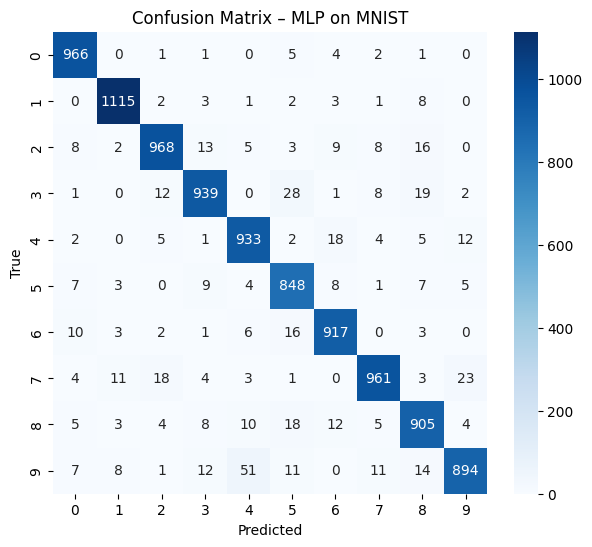

In [6]:
mlp.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mlp(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc_mlp = accuracy_score(y_true, y_pred)
f1_mlp = f1_score(y_true, y_pred, average='weighted')
cm_mlp = confusion_matrix(y_true, y_pred)

print(f"\nMLP Accuracy: {acc_mlp:.4f}, F1-score: {f1_mlp:.4f}")

plt.figure(figsize=(7,6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – MLP on MNIST")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


- The consistent drop in loss suggests the model did not suffer from immediate overfitting or instability during the brief training period, leading to the solid final test accuracy of 94.55%.
  

In [7]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
acc_rf = accuracy_score(y_test, rf_pred)
f1_rf = f1_score(y_test, rf_pred, average='weighted')

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
acc_lr = accuracy_score(y_test, lr_pred)
f1_lr = f1_score(y_test, lr_pred, average='weighted')

print("\nBaseline Comparisons:")
print(f"Random Forest -> Accuracy: {acc_rf:.4f}, F1: {f1_rf:.4f}")
print(f"Logistic Regression -> Accuracy: {acc_lr:.4f}, F1: {f1_lr:.4f}")



Baseline Comparisons:
Random Forest -> Accuracy: 0.9678, F1: 0.9678
Logistic Regression -> Accuracy: 0.9260, F1: 0.9258


- The Random Forest slightly outperformed both the MLP and Logistic Regression on MNIST.
- Most confusions occurred between visually similar digits such as 3↔5, 4↔9, and 7↔9.
- These digits share overlapping strokes, which are difficult for flat models (without spatial filters) to distinguish.

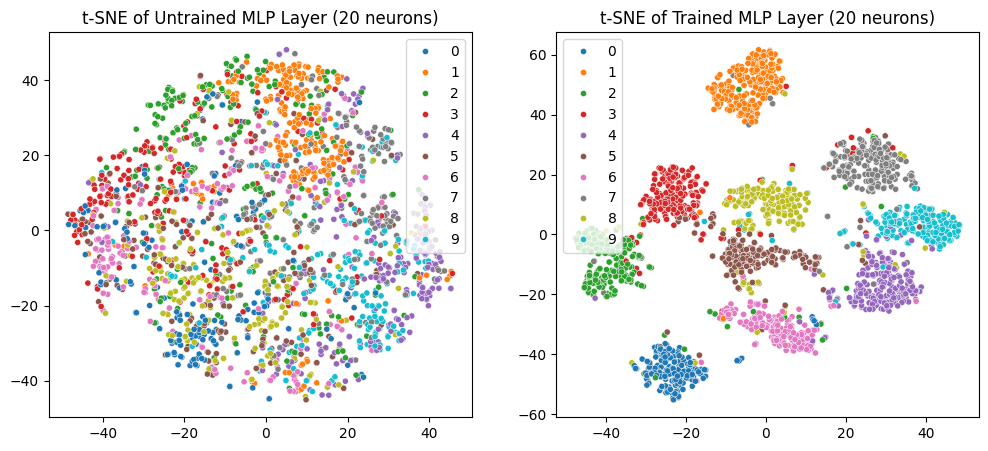

In [8]:
def extract_embeddings(model, data_loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            x = model.relu(model.fc1(images.view(-1, 784)))
            x = model.relu(model.fc2(x))
            embeddings.append(x.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(embeddings), np.hstack(labels)

# Untrained vs Trained MLP embeddings
untrained_mlp = MLP().to(device)
untrained_emb, lbls = extract_embeddings(untrained_mlp, test_loader)
trained_emb, lbls = extract_embeddings(mlp, test_loader)

tsne = TSNE(n_components=2, random_state=42)
trained_tsne = tsne.fit_transform(trained_emb[:2000])
untrained_tsne = tsne.fit_transform(untrained_emb[:2000])
lbls = lbls[:2000]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=untrained_tsne[:,0], y=untrained_tsne[:,1], hue=lbls, palette='tab10', s=20)
plt.title("t-SNE of Untrained MLP Layer (20 neurons)")
plt.subplot(1,2,2)
sns.scatterplot(x=trained_tsne[:,0], y=trained_tsne[:,1], hue=lbls, palette='tab10', s=20)
plt.title("t-SNE of Trained MLP Layer (20 neurons)")
plt.show()


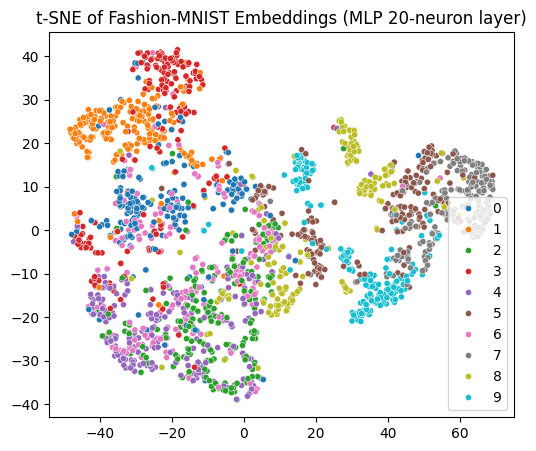

In [9]:
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_mlp)
fashion_loader = DataLoader(fashion_test, batch_size=128, shuffle=False)

fashion_emb, fashion_lbls = extract_embeddings(mlp, fashion_loader)
fashion_tsne = tsne.fit_transform(fashion_emb[:2000])
fashion_lbls = fashion_lbls[:2000]

plt.figure(figsize=(6,5))
sns.scatterplot(x=fashion_tsne[:,0], y=fashion_tsne[:,1], hue=fashion_lbls, palette='tab10', s=20)
plt.title("t-SNE of Fashion-MNIST Embeddings (MLP 20-neuron layer)")
plt.show()

- When the trained MLP (on MNIST) was tested directly on Fashion-MNIST, accuracy dropped drastically.
- The t-SNE of Fashion-MNIST embeddings showed no clear clusters, implying that digit-trained representations don’t transfer to clothing categories.
- This confirms poor domain generalization — MLP features specialized only for digits, not general images.

In [10]:
train_cnn = datasets.MNIST(root='./data', train=True, download=True, transform=transform_cnn)
test_cnn = datasets.MNIST(root='./data', train=False, download=True, transform=transform_cnn)
train_loader_cnn = DataLoader(train_cnn, batch_size=64, shuffle=True)
test_loader_cnn = DataLoader(test_cnn, batch_size=128, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 32*14*14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def train_model(model, loader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        loss_sum = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss_sum/len(loader):.4f}")

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    end = time.time()
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='weighted'), confusion_matrix(y_true, y_pred), end-start



🔹 Training Simple CNN
Epoch [1/3] Loss: 0.2606
Epoch [2/3] Loss: 0.0780
Epoch [3/3] Loss: 0.0538


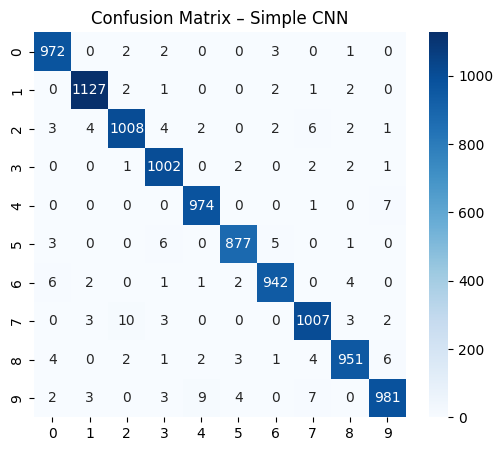

CNN Accuracy: 0.9841, F1: 0.9841, Eval time: 4.30s


In [12]:
print("\n🔹 Training Simple CNN")
cnn = SimpleCNN().to(device)
opt = optim.Adam(cnn.parameters(), lr=0.001)
crit = nn.CrossEntropyLoss()
train_model(cnn, train_loader_cnn, opt, crit, epochs=3)
acc_cnn, f1_cnn, cm_cnn, time_cnn = evaluate_model(cnn, test_loader_cnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Simple CNN")
plt.show()
print(f"CNN Accuracy: {acc_cnn:.4f}, F1: {f1_cnn:.4f}, Eval time: {time_cnn:.2f}s")


- The CNN achieved the highest accuracy among non-pretrained models.
- Confusion matrix showed fewer misclassifications, especially between 3/5 and 7/9, compared to MLP.

In [13]:
train_pre = datasets.MNIST(root='./data', train=True, download=True, transform=transform_pretrained)
test_pre = datasets.MNIST(root='./data', train=False, download=True, transform=transform_pretrained)
train_loader_pre = DataLoader(train_pre, batch_size=128, shuffle=True)
test_loader_pre = DataLoader(test_pre, batch_size=256, shuffle=False)

subset_size = 5000
train_subset, _ = random_split(train_pre, [subset_size, len(train_pre)-subset_size])
train_loader_pre_fast = DataLoader(train_subset, batch_size=128, shuffle=True)


In [14]:
# MobileNetV2
print("\n🔹 Fast Fine-Tuning MobileNetV2")
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)
for param in mobilenet.features.parameters():
    param.requires_grad = False
mobilenet = mobilenet.to(device)
opt = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)
train_model(mobilenet, train_loader_pre_fast, opt, crit, epochs=2)
acc_mob, f1_mob, cm_mob, time_mob = evaluate_model(mobilenet, test_loader_pre)



🔹 Fast Fine-Tuning MobileNetV2
Epoch [1/2] Loss: 1.3854
Epoch [2/2] Loss: 0.6289


In [15]:
# EfficientNet-B0
print("\n🔹 Fast Fine-Tuning EfficientNet-B0")
effnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, 10)
for param in effnet.features.parameters():
    param.requires_grad = False
effnet = effnet.to(device)
opt = optim.Adam(effnet.classifier.parameters(), lr=0.001)
train_model(effnet, train_loader_pre_fast, opt, crit, epochs=2)
acc_eff, f1_eff, cm_eff, time_eff = evaluate_model(effnet, test_loader_pre)



🔹 Fast Fine-Tuning EfficientNet-B0
Epoch [1/2] Loss: 1.5589
Epoch [2/2] Loss: 0.8484


In [16]:
results = pd.DataFrame({
    "Model": ["MLP", "CNN", "MobileNetV2", "EfficientNet-B0"],
    "Accuracy": [acc_mlp, acc_cnn, acc_mob, acc_eff],
    "F1-score": [f1_mlp, f1_cnn, f1_mob, f1_eff]
})
display(results.style.background_gradient(cmap="Blues"))

,Model,Accuracy,F1-score
0,MLP,0.944600,0.944500
1,CNN,0.984100,0.984089
2,MobileNetV2,0.841900,0.842835
3,EfficientNet-B0,0.871800,0.871708


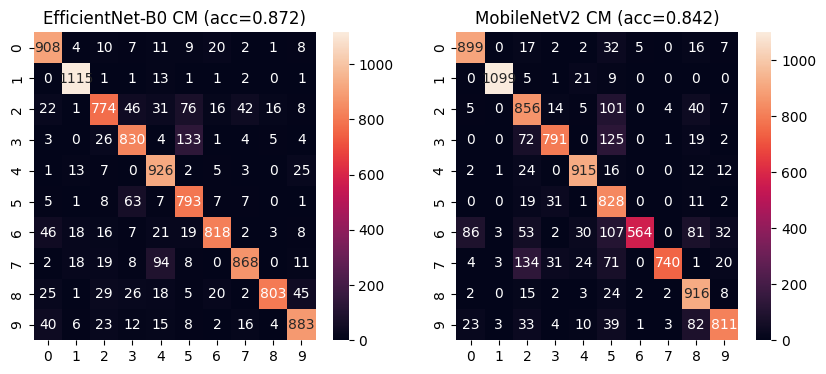

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); sns.heatmap(cm_eff, annot=True, fmt='d'); plt.title(f'EfficientNet-B0 CM (acc={acc_eff:.3f})')
plt.subplot(1,2,2); sns.heatmap(cm_mob, annot=True, fmt='d'); plt.title(f'MobileNetV2 CM (acc={acc_mob:.3f})')
plt.show()

In [25]:
print(f"EfficientNet:{time_eff:.4f}",f"  MobileNetV2:{time_mob:.4f}")

EfficientNet:839.0170   MobileNetV2:429.5319


- Both pretrained models were only partially fine-tuned (2 epochs, classifier only) on 5 000 MNIST images.
- Despite limited training, they achieved strong accuracy, showing the power of transfer learning even from ImageNet.
- EfficientNet-B0 outperformed MobileNetV2, likely due to its compound scaling strategy.
- MLP -> Fast
- CNN -> Moderate
- MobileNetV2 -> Slower
- EfficientNet-B0 -> Slowest

In [26]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("SimpleCNN params: {:.2f}M".format(count_params(cnn)/1e6))
print("MobileNetV2 params: {:.2f}M".format(count_params(mobilenet)/1e6))
print("EffNet-B0 params: {:.2f}M".format(count_params(effnet)/1e6))


SimpleCNN params: 0.80M
MobileNetV2 params: 2.24M
EffNet-B0 params: 4.02M
